<a href="https://colab.research.google.com/github/MusaibBashir/ml/blob/main/Logistic_Regression_Trains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
df=pd.read_csv('train_log_reg.csv')

In [3]:
print("Dataset Preview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nTarget Distribution:")
print(df['train_number'].value_counts().sort_index())


Dataset Preview:
  departure_station arrival_station departure_time arrival_time day_of_week  \
0        Providence        New York          14:00        17:45     Tuesday   
1     Washington DC      Providence          17:30        20:00     Tuesday   
2         New Haven         Trenton          15:45        17:30      Sunday   
3           Chicago      Providence          20:45        22:30     Tuesday   
4        Providence    Philadelphia          16:30        19:45     Tuesday   

  train_type  distance_km  train_number  
0      Local          311            10  
1      Local          166            10  
2    Express          119             6  
3    Express          129             5  
4      Local          229             9  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   departure_station  1000 non-null   ob

In [4]:
categorical_features = ['departure_station', 'arrival_station', 'day_of_week', 'train_type']
numerical_features = ['distance_km']
time_features = ['departure_time', 'arrival_time']


In [5]:
def time_to_minutes(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

In [6]:
df['departure_minutes'] = df['departure_time'].apply(time_to_minutes)
df['arrival_minutes'] = df['arrival_time'].apply(time_to_minutes)
df.loc[df['arrival_minutes'] < df['departure_minutes'], 'arrival_minutes'] += 24 * 60
df['trip_duration_minutes'] = df['arrival_minutes'] - df['departure_minutes']
numerical_features = ['distance_km', 'departure_minutes', 'arrival_minutes', 'trip_duration_minutes']
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=False)
X = df_encoded.drop(['departure_time', 'arrival_time', 'train_number'], axis=1)
y = df['train_number']


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

for feature in numerical_features:
    X_train_scaled[feature] = scaler.fit_transform(X_train_scaled[[feature]])
    X_test_scaled[feature] = scaler.transform(X_test_scaled[[feature]])


In [8]:
class MulticlassLogisticRegression:
    def __init__(self, learning_rate=0.01, iterations=1000, classes=None):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.classes = classes
        self.weights = None
        self.biases = None

    def softmax(self, z):
        z = np.array(z, dtype=float)
        if z.ndim == 1:
            z = z.reshape(1, -1)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot_encode(self, y):
        n_samples = len(y)
        n_classes = len(self.classes)
        y_encoded = np.zeros((n_samples, n_classes))
        for i, class_idx in enumerate(y):
            y_encoded[i, class_idx-1] = 1
        return y_encoded

    def initialize_parameters(self, n_features, n_classes):
        limit = np.sqrt(6 / (n_features + n_classes))
        self.weights = np.zeros((n_features, n_classes), dtype=float)
        self.biases = np.zeros(n_classes, dtype=float)

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)

        n_samples, n_features = X.shape
        if self.classes is None:
            self.classes = np.unique(y)
        n_classes = len(self.classes)

        self.initialize_parameters(n_features, n_classes)

        y_encoded = self.one_hot_encode(y)

        cost_history = []

        # Gradient descent
        for i in range(self.iterations):
            z = np.dot(X, self.weights) + self.biases
            y_pred = self.softmax(z)

            cost = -np.sum(y_encoded * np.log(y_pred + 1e-10)) / n_samples
            cost_history.append(cost)

            dz = y_pred - y_encoded
            dw = (X.T @ dz) / n_samples
            db = np.sum(dz, axis=0) / n_samples

            dw = np.asarray(dw, dtype=float)
            db = np.asarray(db, dtype=float)

            self.weights -= self.learning_rate * dw
            self.biases -= self.learning_rate * db

            # Print progress
            if (i+1) % 100 == 0:
                print(f"Iteration {i+1}/{self.iterations}, Cost: {cost:.4f}")

        return cost_history

    def predict_proba(self, X):
        X = np.array(X)
        z = np.dot(X, self.weights) + self.biases
        return self.softmax(z)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1) + 1

In [9]:
model = MulticlassLogisticRegression(learning_rate=0.005, iterations=2500)
cost_history = model.fit(X_train_scaled, y_train)


Iteration 100/2500, Cost: 2.2364
Iteration 200/2500, Cost: 2.1783
Iteration 300/2500, Cost: 2.1276
Iteration 400/2500, Cost: 2.0831
Iteration 500/2500, Cost: 2.0437
Iteration 600/2500, Cost: 2.0087
Iteration 700/2500, Cost: 1.9771
Iteration 800/2500, Cost: 1.9486
Iteration 900/2500, Cost: 1.9226
Iteration 1000/2500, Cost: 1.8988
Iteration 1100/2500, Cost: 1.8769
Iteration 1200/2500, Cost: 1.8566
Iteration 1300/2500, Cost: 1.8377
Iteration 1400/2500, Cost: 1.8201
Iteration 1500/2500, Cost: 1.8036
Iteration 1600/2500, Cost: 1.7881
Iteration 1700/2500, Cost: 1.7735
Iteration 1800/2500, Cost: 1.7598
Iteration 1900/2500, Cost: 1.7468
Iteration 2000/2500, Cost: 1.7344
Iteration 2100/2500, Cost: 1.7227
Iteration 2200/2500, Cost: 1.7116
Iteration 2300/2500, Cost: 1.7010
Iteration 2400/2500, Cost: 1.6908
Iteration 2500/2500, Cost: 1.6812


In [10]:
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)


Accuracy: 0.3200

Classification Report:
              precision    recall  f1-score   support

           1       0.41      0.57      0.48        21
           2       0.00      0.00      0.00        17
           3       0.30      0.92      0.46        25
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        16
           6       0.25      0.38      0.30         8
           7       0.12      0.07      0.09        15
           8       0.50      0.07      0.12        28
           9       0.21      0.29      0.24        21
          10       0.40      0.63      0.49        27

    accuracy                           0.32       200
   macro avg       0.22      0.29      0.22       200
weighted avg       0.25      0.32      0.24       200


Confusion Matrix:
[[12  0  9  0  0  0  0  0  0  0]
 [11  0  6  0  0  0  0  0  0  0]
 [ 2  0 23  0  0  0  0  0  0  0]
 [ 3  0 19  0  0  0  0  0  0  0]
 [ 1  0 13  0  0  0  2  0  0  0]
 [ 0  0  1  0  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


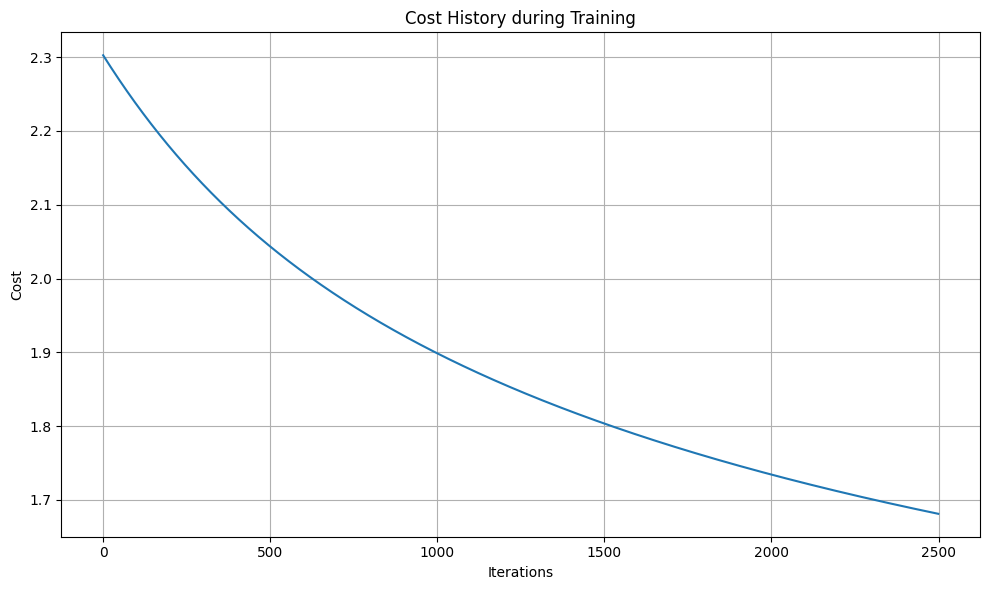

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title("Cost History during Training")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.grid(True)
plt.tight_layout()
plt.savefig("cost_history.png")

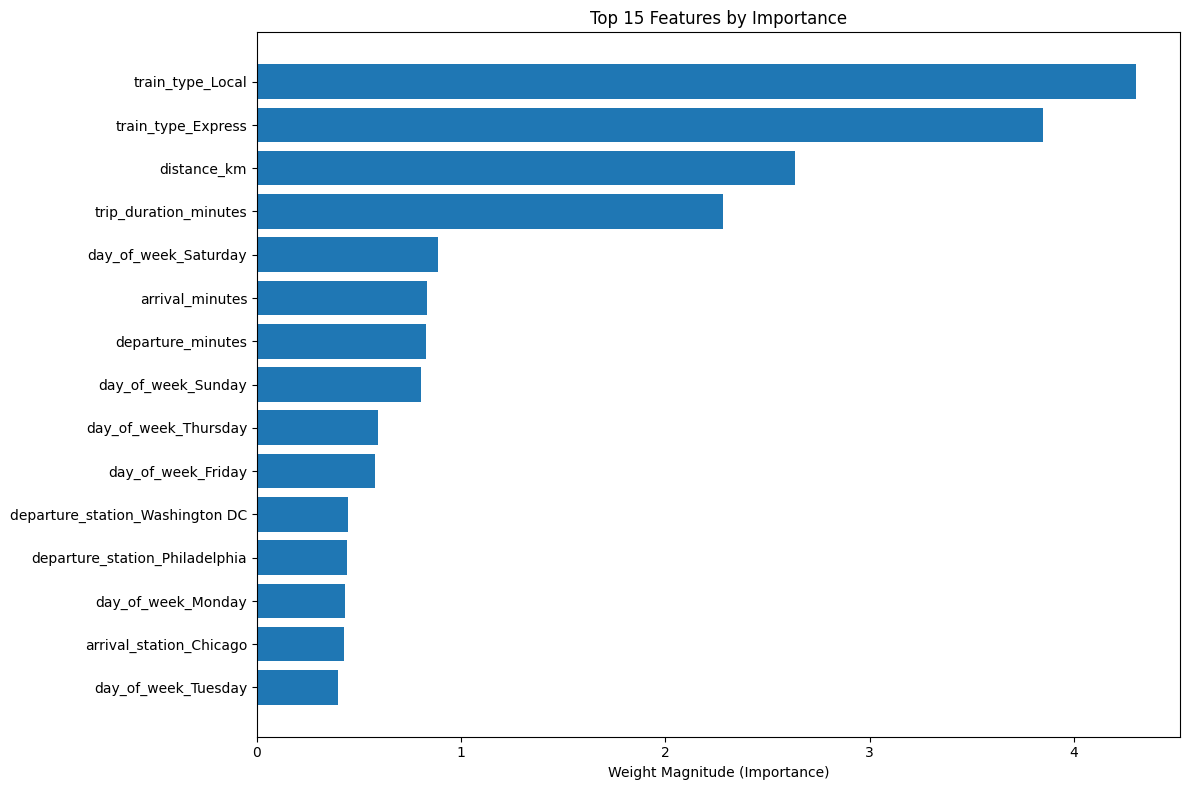

In [12]:
feature_names = X_train.columns
weights_magnitude = np.sum(np.abs(model.weights), axis=1)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': weights_magnitude
})
feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title("Top 15 Features by Importance")
plt.xlabel("Weight Magnitude (Importance)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance.png")

In [13]:
print("\nModel Summary:")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y_train))}")
print(f"Learning rate: {model.learning_rate}")
print(f"Final cost: {cost_history[-1]:.4f}")



Model Summary:
Number of features: 33
Number of classes: 10
Learning rate: 0.005
Final cost: 1.6812


In [14]:
weights_df = pd.DataFrame(model.weights, index=X_train.columns)
weights_df.to_csv('model_weights.csv')

print("\nSample of Model Weights (first 3 classes):")
print(weights_df.iloc[:, :3].head())
biases_df = pd.DataFrame(model.biases).T
biases_df.columns = weights_df.columns
biases_df.to_csv('model_biases.csv', index=False)
# Print biases
print("\nModel Biases:")
print(model.biases)



Sample of Model Weights (first 3 classes):
                                    0         1         2
distance_km                  0.492470  0.247140 -0.099729
departure_minutes           -0.026575 -0.159356  0.018973
arrival_minutes              0.103851 -0.094462  0.002664
trip_duration_minutes        0.492083  0.221526 -0.059037
departure_station_Baltimore  0.010697 -0.038462  0.068817

Model Biases:
[-0.12057381 -0.24995117  0.22996142  0.01670844 -0.10314018 -0.09827624
 -0.10287852  0.11069419  0.16603864  0.15141722]


In [15]:
print("\nPrediction Example:")
example_train = X_test_scaled.iloc[0:1]
predicted_proba = model.predict_proba(example_train)
predicted_class = model.predict(example_train)[0]
print(f"Predicted train number: {predicted_class}")
print(f"Probabilities: {predicted_proba[0]}")


Prediction Example:
Predicted train number: 3
Probabilities: [0.04979394 0.04243473 0.29473672 0.18810094 0.11573364 0.10596095
 0.06916892 0.05447808 0.04057547 0.03901661]


In [16]:
print("\nFeatures of this example:")
for col in ['departure_station', 'arrival_station', 'departure_time', 'arrival_time',
            'day_of_week', 'train_type', 'distance_km']:
    if col in df.columns:
        print(f"{col}: {df.iloc[X_test.index[0]][col]}")

print("\nActual train number:", y_test.iloc[0])


Features of this example:
departure_station: Chicago
arrival_station: Providence
departure_time: 15:30
arrival_time: 17:15
day_of_week: Monday
train_type: Express
distance_km: 129

Actual train number: 4
